In [1]:
# Import necessary Libraries 
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from scipy import stats
import pylab
from sklearn.linear_model import LinearRegression
from sklearn import metrics


C:\Users\raghu\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# An utility function to create dummy variable
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname)
    col_dummies.drop(col_dummies.columns[0], axis=1, inplace=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

In [3]:
# Import Data 
data=pd.read_csv("3. CREDIT CARD SPEND PREDICTION PROBLEM- BANKING-REGRESSION//CREDIT CARD USERS DATA.csv")

C:\Users\raghu\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (2,19,21,49,87,88,102) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
data.head()

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,3964-QJWTRG-NPN,1.0,2.00,1.0,20.0,2.0,September,15.0,3.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0648-AIPJSP-UVM,5.0,5.00,0.0,22.0,2.0,May,17.0,4.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2,5195-TLUDJE-HVO,3.0,4.00,1.0,67.0,6.0,June,14.0,2.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,4459-VLPQUH-3OL,4.0,3.00,0.0,23.0,2.0,May,16.0,3.0,2.0,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
4,8158-SMTQFB-CNO,2.0,2.00,0.0,26.0,3.0,July,16.0,3.0,2.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [5]:
# Creating list of all columns present in the data
allcolumn=[]
for variable in data.columns:
    allcolumn.append(variable)

In [6]:
# " start_ln " columns starting with "ln" -> They have some error so high no. of missing values so deleting them 
start_ln=data.columns.str.startswith('ln')
# Creating a numpy array of all columns 
allcolumn_array=np.asarray(allcolumn)
# " Z " is the column names in all column of data which starts with word "ln"
z=allcolumn_array[start_ln]
# " var_to_remove " -> List that contain column names to delete starting with 'ln'
var_to_remove=[]
for var in z:
    var_to_remove.append(var)

# " var_to_log "-> Variables for which log transformation is to be taken 
var_to_log=[]
for var in var_to_remove:
    var_to_log.append(var[2:])
   


In [7]:
# Variable " inc " is " income "
var_to_log[0]='income'

In [8]:
# Dropping Variables starting with "ln" is "var_to_remove" variables 
data.drop(var_to_remove,axis=1,inplace=True)

In [9]:
data.select_dtypes('object').columns ## The object column here and in the data dictionary does not match.

Index(['custid', 'townsize', 'birthmonth', 'commutetime', 'longten',
       'cardten'],
      dtype='object')

In [10]:
# Selecting categorical variables and adding to list 
var_cat=[]
for variable in data.select_dtypes('object').columns:
    var_cat.append(variable)

var_cat=var_cat[1:] ## CustID is surely categorical so leaving that 

In [11]:
# Categorical variable based on Data Dictionary
var_cat_real=['region','townsize','gender','agecat','birthmonth','edcat','jobcat','union','employ','empcat','retire','inccat','default','jobsat','marital','spousedcat','homeown','hometype','address','addresscat','cars','carown','cartype','carcatvalue','carbought','carbuy','commute','commutecat','commutecar','commutemotorcycle','commutecarpool','commutebus','commuterail','commutepublic','commutebike','commutewalk','commutenonmotor','telecommute','reason','polview','polparty','polcontrib','vote','card','cardtype','cardbenefit','cardfee','cardtenure','cardtenurecat','card2','card2type','card2benefit','card2fee','card2tenure','card2tenurecat','active','bfast','churn','tollfree','equip','callcard','wireless','multline','voice','pager','internet','callid','callwait','forward','confer','ebill','owntv','ownvcr','owndvd','owncd','ownpda','ownpc','ownipod','owngame','ownfax','news','response_01','response_02','response_03']

In [12]:
# Adding both variable to a set 
var_cat_real_set=set(var_cat_real)
var_cat_set=set(var_cat)

In [13]:
var_cat_real_set.intersection(var_cat_set) # These both variable are actually categorical and has been shown as categorical

{'birthmonth', 'townsize'}

In [14]:
var_cat_1=list(var_cat_real_set-var_cat_real_set.intersection(var_cat_set)) ## Variables which are to be converted to categorical 

In [15]:
# variables which are numerical but found as categorical due to Null values 
var_cat_2=list(var_cat_set-var_cat_real_set.intersection(var_cat_set))

In [16]:
# Null values are indicated by "#NULL!" which is a string due to which variables become object datatype.replacing them by "np.NaN"
data=data.replace(to_replace="#NULL!", value=np.NaN)

In [17]:
# Finding missing value in variables  
miss=data.isna().sum()
miss1=miss[miss.values>0]

# variables which are to be dropped due to high missing values are added to separate series 
miss2=miss[miss.values>1000]

In [18]:
# All variables containing missing values 
miss1

townsize       2
commutetime    2
longten        3
cardten        2
dtype: int64

In [19]:
# Now missing which is to be imputed are left 
miss1

townsize       2
commutetime    2
longten        3
cardten        2
dtype: int64

In [20]:
# Adding the variables to a list 
miss1_var=[]
for variable in miss1.index:
    miss1_var.append(variable)

In [21]:
var_cat_real_set.intersection(set(miss1_var)) ## Categorical variable to be imputed 

{'townsize'}

In [22]:
data[data.townsize.isna()==True] # Shows there are 2 rows for which "townsize " is missing  

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
961,3622-JHDLVP-V1E,1.0,NaN,1.0,48.0,4.0,January,19.0,4.0,3.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2731,0860-BRGALK-LLR,5.0,NaN,1.0,68.0,6.0,February,15.0,3.0,6.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
data[(data.townsize==1.0)].count() # Count is 255 which is not true

custid           255
region           255
townsize         255
gender           255
age              255
agecat           255
birthmonth       255
ed               255
edcat            255
jobcat           255
union            255
employ           255
empcat           255
retire           255
income           255
inccat           255
debtinc          255
creddebt         255
othdebt          255
default          255
jobsat           255
marital          255
spoused          255
spousedcat       255
reside           255
pets             255
pets_cats        255
pets_dogs        255
pets_birds       255
pets_reptiles    255
                ... 
equipten         255
callcard         255
cardmon          255
cardten          255
wireless         255
wiremon          255
wireten          255
multline         255
voice            255
pager            255
internet         255
callid           255
callwait         255
forward          255
confer           255
ebill            255
owntv        

In [24]:
# Count is 1436 which is true this confirms the value 1 is written as numerical 1.0 and string 1.00 so convert it to float to ease calculation
data[(data.townsize==1.0)|(data.townsize=='1.00')].count()
  

custid           1436
region           1436
townsize         1436
gender           1436
age              1436
agecat           1436
birthmonth       1436
ed               1436
edcat            1436
jobcat           1436
union            1436
employ           1436
empcat           1436
retire           1436
income           1436
inccat           1436
debtinc          1436
creddebt         1436
othdebt          1436
default          1436
jobsat           1436
marital          1436
spoused          1436
spousedcat       1436
reside           1436
pets             1436
pets_cats        1436
pets_dogs        1436
pets_birds       1436
pets_reptiles    1436
                 ... 
equipten         1436
callcard         1436
cardmon          1436
cardten          1436
wireless         1436
wiremon          1436
wireten          1436
multline         1436
voice            1436
pager            1436
internet         1436
callid           1436
callwait         1436
forward          1436
confer    

In [25]:
data.townsize=data.townsize.astype(float) # Converting "townsize" variable to float 

In [26]:
data[data.townsize==1.0].count()  # 1436 -- Actual value 

custid           1436
region           1436
townsize         1436
gender           1436
age              1436
agecat           1436
birthmonth       1436
ed               1436
edcat            1436
jobcat           1436
union            1436
employ           1436
empcat           1436
retire           1436
income           1436
inccat           1436
debtinc          1436
creddebt         1436
othdebt          1436
default          1436
jobsat           1436
marital          1436
spoused          1436
spousedcat       1436
reside           1436
pets             1436
pets_cats        1436
pets_dogs        1436
pets_birds       1436
pets_reptiles    1436
                 ... 
equipten         1436
callcard         1436
cardmon          1436
cardten          1436
wireless         1436
wiremon          1436
wireten          1436
multline         1436
voice            1436
pager            1436
internet         1436
callid           1436
callwait         1436
forward          1436
confer    

In [27]:
# Categorical value so filling by mode 
data['townsize']=data['townsize'].fillna(value=float(data['townsize'].mode()))

In [28]:
data[data.townsize.isna()==True] # Comfirming there is no missing value

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03


### Now Handling Numerical missing values so converting variables to float 


In [29]:
# Numercal Variables = All variables - Real Categorical variables 
miss1_var_num=list(set(miss1_var)-var_cat_real_set.intersection(set(miss1_var))) 

In [30]:
miss1_var_num 

['cardten', 'commutetime', 'longten']

In [31]:
for variable in miss1_var_num:
    data[variable]=data[variable].astype(float) # Conveting variables to float 
    data[variable]=data[variable].fillna(data[variable].median()) # Using "median" to fill "NaN" because outliers have not been treated 

In [32]:
# Confirming that there is No Missing values 
miss=data.isna().sum()
miss1=miss[miss.values>0]
miss1

Series([], dtype: int64)

### Getting names of Numerical variable for outlier treatment 

In [33]:
# Adding all Column to a list   
data_var_all=[]
for variable in data.columns:
    data_var_all.append(variable)

In [34]:
# Getting numerical variables -> Numerical variable = All variable - Real categorical variables 
data_num_var=list(set(data_var_all)-set(var_cat_real))

In [35]:
data_num_var.remove('custid') # " custid " is nor a categorical nor numeric. So removing it 

In [36]:
# Outlier Treatment at 99%ile and 1%ile 
for variable in data_num_var:
    data[variable]=data[variable].clip_upper(data[variable].quantile(0.99))
    data[variable]=data[variable].clip_lower(data[variable].quantile(0.01))
        

### Separating categorical and numerical variable and changing to respective data type

In [37]:
data.select_dtypes('object').columns # as of now only two categorical variable 

Index(['custid', 'birthmonth'], dtype='object')

In [38]:
data.head()

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,3964-QJWTRG-NPN,1.0,2.0,1.0,20.0,2.0,September,15.0,3.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0648-AIPJSP-UVM,5.0,5.0,0.0,22.0,2.0,May,17.0,4.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2,5195-TLUDJE-HVO,3.0,4.0,1.0,67.0,6.0,June,14.0,2.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,4459-VLPQUH-3OL,4.0,3.0,0.0,23.0,2.0,May,16.0,3.0,2.0,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
4,8158-SMTQFB-CNO,2.0,2.0,0.0,26.0,3.0,July,16.0,3.0,2.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [39]:
# Converting "birthmonth" to "object" and creating dummies 
var_cat_real.remove('birthmonth')
data['birthmonth']=data['birthmonth'].astype('object')
data=create_dummies(data,'birthmonth') 

In [40]:
# Making variable categorical and converting them to dummies 
for variable in var_cat_real:
    data[variable]=data[variable].astype('int')
    data[variable]=data[variable].astype('object')
    data=create_dummies(data,variable)       

In [41]:
data.head()

,custid,age,ed,income,debtinc,creddebt,othdebt,spoused,reside,pets,...,owncd_1,ownpda_1,ownpc_1,ownipod_1,owngame_1,ownfax_1,news_1,response_01_1,response_02_1,response_03_1
0,3964-QJWTRG-NPN,20.0,15.0,31.0,11.1,1.20,2.24,-1.0,3.0,0.0,...,0,0,0,1,1,0,0,0,1,0
1,0648-AIPJSP-UVM,22.0,17.0,15.0,18.6,1.22,1.57,-1.0,2.0,6.0,...,1,1,1,1,1,1,1,0,0,0
2,5195-TLUDJE-HVO,67.0,14.0,35.0,9.9,0.93,2.54,13.0,3.0,3.0,...,1,0,0,0,0,0,1,0,0,0
3,4459-VLPQUH-3OL,23.0,16.0,20.0,5.7,0.03,1.12,18.0,5.0,0.0,...,1,0,1,1,1,0,1,1,0,0
4,8158-SMTQFB-CNO,26.0,16.0,23.0,1.7,0.21,0.18,13.0,4.0,0.0,...,1,0,1,0,1,0,0,0,1,0


In [42]:
data['totalspent']=data['cardspent']+data['card2spent'] # Creating " Y "variable as "totalspent"

In [43]:
data.drop(['cardspent','card2spent'],axis=1,inplace=True) # Dropping variable 

In [44]:
data.drop('custid',axis=1,inplace=True) # Dropping "custid" because it is not used in any analysis 

In [45]:
# Taking log transformation of "y" variable ie "totalspent" beacuse it is not normal  
data['totalspent']=np.log(data['totalspent']+1)

### Making First Model 

In [46]:
#Splitting the Columns
feature_columns = data.columns.difference( ['totalspent'] )

In [47]:
# Splitting the Data 
train_X, test_X, train_y, test_y = train_test_split( data[feature_columns],
                                                  data['totalspent'],
                                                  test_size = 0.3,
                                                  random_state = 123 )

In [48]:
# Adding Constant in Train Data and Buliding a OLS(Oridinay Least Square) Linear Regression 
import statsmodels.api as sm
train_X = sm.add_constant(train_X)
lm=sm.OLS(train_y,train_X).fit()

In [49]:
# Sorting p_values in descending order
summary_pvalue=lm.pvalues.sort_values(ascending=False)

In [50]:
summary_pvalue

address_15           9.996580e-01
inccat_5             9.975532e-01
cardtenure_35        9.936878e-01
card2tenure_13       9.929563e-01
address_54           9.918478e-01
cardtenure_14        9.850369e-01
polcontrib_1         9.850157e-01
carbought_1          9.824322e-01
cars_1               9.783601e-01
card2tenure_14       9.771210e-01
commutecat_4         9.755387e-01
region_3             9.694335e-01
card2tenurecat_5     9.672653e-01
address_9            9.649925e-01
cardtenure_19        9.500495e-01
polview_3            9.483189e-01
forward_1            9.444252e-01
commute_4            9.437780e-01
jobsat_3             9.360630e-01
cardtenure_37        9.353070e-01
ebill_1              9.350520e-01
townsize_2           9.342869e-01
cardtenure_13        9.310631e-01
address_42           9.310241e-01
ownfax_1             9.287878e-01
address_41           9.284087e-01
callwait_1           9.281421e-01
edcat_5              9.280813e-01
employ_46            9.266128e-01
address_24    

In [51]:
# Taking variables which have p-value less than 0.02
while(summary_pvalue[0])>0.02:
    train_X.drop(summary_pvalue.index[0],axis=1,inplace=True)
    lm=sm.OLS(train_y,train_X).fit()
    summary_pvalue=lm.pvalues.sort_values(ascending=False)   

In [52]:
# Linear Regression Summary
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:             totalspent   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     255.0
Date:                Sat, 27 Oct 2018   Prob (F-statistic):               0.00
Time:                        16:31:17   Log-Likelihood:                -1323.4
No. Observations:                3500   AIC:                             2715.
Df Residuals:                    3466   BIC:                             2924.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.0151      0.065     76.

In [53]:
train_X.columns

Index(['const', 'age', 'agecat_3', 'agecat_4', 'agecat_5', 'agecat_6',
       'card2_2', 'card2_3', 'card2_4', 'card2_5', 'card2items',
       'card2tenure_26', 'card_2', 'card_3', 'card_4', 'card_5', 'carditems',
       'cardtenure_39', 'ed', 'employ_16', 'employ_32', 'employ_34',
       'equipten', 'gender_1', 'inccat_2', 'inccat_3', 'inccat_4', 'income',
       'owncd_1', 'polview_6', 'reason_2', 'reason_9', 'retire_1', 'tenure'],
      dtype='object')

In [54]:
# Calculating VIF for selected variables for Multicollinearity 
X = pd.concat([train_X,data['totalspent']], axis=1)
features = "+".join(train_X.columns)
X.head()
a,b = dmatrices(formula_like='totalspent ~ '+ features, data = X, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif["features"] = b.columns

print(vif)

C:\Users\raghu\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1543: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


    VIF Factor        features
0     0.000000       Intercept
1     0.000000           const
2    22.600942             age
3     2.876626        agecat_3
4     8.234759        agecat_4
5    18.768943        agecat_5
6    30.632207        agecat_6
7     2.077937         card2_2
8     2.131673         card2_3
9     2.272068         card2_4
10    1.448575         card2_5
11    1.060482      card2items
12    1.053362  card2tenure_26
13    2.059745          card_2
14    2.042488          card_3
15    2.316639          card_4
16    1.319339          card_5
17    1.038175       carditems
18    1.108708   cardtenure_39
19    1.385475              ed
20    1.028039       employ_16
21    1.021710       employ_32
22    1.039226       employ_34
23    1.306136        equipten
24    1.019738        gender_1
25    1.886849        inccat_2
26    1.604392        inccat_3
27    1.503752        inccat_4
28    1.885021          income
29    1.186701         owncd_1
30    1.026666       polview_6
31    1.

In [55]:
vif.sort_values('VIF Factor',ascending=False)

,VIF Factor,features
6,30.632207,agecat_6
2,22.600942,age
5,18.768943,agecat_5
4,8.234759,agecat_4
3,2.876626,agecat_3
33,2.844323,retire_1
15,2.316639,card_4
9,2.272068,card2_4
8,2.131673,card2_3
7,2.077937,card2_2


In [56]:
train_X.drop('agecat_6',axis=1,inplace=True)

In [57]:
X = pd.concat([train_X,data['totalspent']], axis=1)
features = "+".join(train_X.columns)
X.head()
a,b = dmatrices(formula_like='totalspent ~ '+ features, data = X, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif["features"] = b.columns

print(vif)

C:\Users\raghu\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1543: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


    VIF Factor        features
0     0.000000       Intercept
1     0.000000           const
2     3.232639             age
3     1.775659        agecat_3
4     1.813702        agecat_4
5     1.766884        agecat_5
6     2.077896         card2_2
7     2.131626         card2_3
8     2.271948         card2_4
9     1.448493         card2_5
10    1.060454      card2items
11    1.053286  card2tenure_26
12    2.059413          card_2
13    2.042483          card_3
14    2.316367          card_4
15    1.318816          card_5
16    1.038108       carditems
17    1.107788   cardtenure_39
18    1.385423              ed
19    1.027683       employ_16
20    1.021566       employ_32
21    1.039195       employ_34
22    1.306099        equipten
23    1.019738        gender_1
24    1.879636        inccat_2
25    1.601136        inccat_3
26    1.496934        inccat_4
27    1.883705          income
28    1.186624         owncd_1
29    1.026650       polview_6
30    1.465957        reason_2
31    1.

In [58]:
vif.sort_values('VIF Factor',ascending=False)

,VIF Factor,features
2,3.232639,age
32,2.842130,retire_1
14,2.316367,card_4
8,2.271948,card2_4
7,2.131626,card2_3
6,2.077896,card2_2
12,2.059413,card_2
13,2.042483,card_3
33,1.962726,tenure
27,1.883705,income


### f-regression Works but not working in this case Leave this part and or find error in this part or ask for help from Sir 

In [59]:
# Adding Train Data Column to a List 
train_var_list_f = []
for variable in train_X.columns:
        train_var_list_f.append(variable)

In [60]:
# Applying f_regression on Traing Data 
from sklearn.feature_selection import f_regression
F_values, p_values  = f_regression( train_X, train_y)

C:\Users\raghu\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\Users\raghu\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
C:\Users\raghu\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\raghu\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\raghu\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [61]:
# Adding p-values and features to a New DataFrame 
f_regression_var=pd.DataFrame( )
f_regression_var["features"] = train_X.columns
f_regression_var["f_regression_value"] = [ p_values[i] for i in range(len(p_values))]


In [62]:
# Sorting p_values in descending order
f_regression_var.sort_values('f_regression_value',ascending=False,inplace=True)

In [178]:
f_regression_var

,features,f_regression_value
1,age,8.374771e-01
20,employ_34,6.766474e-01
16,cardtenure_39,4.304357e-01
2,agecat_3,2.516575e-01
30,reason_9,4.830874e-02
19,employ_32,2.535261e-02
18,employ_16,1.869337e-02
10,card2tenure_26,9.131997e-03
32,tenure,8.193962e-03
28,polview_6,4.306004e-03


In [179]:
# Addding the Top 17 Features to a New DataFrame i.e Subsetting DataFrame 
f_regression_var_select=f_regression_var.head(17)

In [180]:
f_regression_var_select

,features,f_regression_value
1,age,0.837477
20,employ_34,0.676647
16,cardtenure_39,0.430436
2,agecat_3,0.251658
30,reason_9,0.048309
19,employ_32,0.025353
18,employ_16,0.018693
10,card2tenure_26,0.009132
32,tenure,0.008194
28,polview_6,0.004306


In [181]:
# Adding the Name of the Features Selected for further use in a List  
select_var_f=[]
for variable in f_regression_var_select.features.values:
    select_var_f.append(variable)
    
select_var_f.append('totalspent')

In [182]:
select_var_f

['age',
 'employ_34',
 'cardtenure_39',
 'agecat_3',
 'reason_9',
 'employ_32',
 'employ_16',
 'card2tenure_26',
 'tenure',
 'polview_6',
 'card2_5',
 'card_5',
 'inccat_2',
 'card2_4',
 'gender_1',
 'agecat_4',
 'card2_3',
 'totalspent']

 ### Using the variables from o

In [183]:
# Subsetting the Data of Selected VAriables/Features to A New DataFrame 
data_select_f=data[select_var_f]

In [184]:
data_select_f.head()

,age,employ_34,cardtenure_39,agecat_3,reason_9,employ_32,employ_16,card2tenure_26,tenure,polview_6,card2_5,card_5,inccat_2,card2_4,gender_1,agecat_4,card2_3,totalspent
0,20.0,0,0,0,1,0,0,0,5.0,1,1,0,1,0,1,0,0,5.013697
1,22.0,0,0,0,1,0,0,0,39.0,0,0,0,0,1,0,0,0,4.363608
2,67.0,0,0,0,0,0,1,0,65.0,0,0,0,1,1,1,0,0,5.888795
3,23.0,0,0,0,1,0,0,0,36.0,0,0,0,0,0,0,0,1,5.887242
4,26.0,0,0,1,1,0,0,0,21.0,0,0,0,0,0,0,0,0,6.232114


In [1]:
feature_columns_f = data_select_f.columns.difference( ['totalspent'] )

NameError: name 'data_select_f' is not defined

In [186]:
feature_columns_f

Index(['age', 'agecat_3', 'agecat_4', 'card2_3', 'card2_4', 'card2_5',
       'card2tenure_26', 'card_5', 'cardtenure_39', 'employ_16', 'employ_32',
       'employ_34', 'gender_1', 'inccat_2', 'polview_6', 'reason_9', 'tenure'],
      dtype='object')

In [187]:
# Splitting the Data 
train_X_f, test_X_f, train_y_f, test_y_f = train_test_split( data_select_f[feature_columns_f],
                                                  data_select_f['totalspent'],
                                                  test_size = 0.3,
                                                  random_state = 123 )

In [188]:
# Training OLS Model on Selected Data  
train_X_f = sm.add_constant(train_X_f)
lm_f=sm.OLS(train_y_f,train_X_f).fit()

In [189]:
lm_f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             totalspent   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     7.662
Date:                Sat, 27 Oct 2018   Prob (F-statistic):           4.23e-19
Time:                        14:20:29   Log-Likelihood:                -3414.9
No. Observations:                3500   AIC:                             6866.
Df Residuals:                    3482   BIC:                             6977.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              6.1101      0.053    114.872      0.000       6.006       6.214
age               -0.0016      0.001     -1.805      0.071      -0.003       0.000
agecat_3           0.0253      0.036      0.713      0.476      -0.044       0.095
agecat_4           0.1214      0.028      4.283      0.000       0.066       0.177
card2_3           -0.1070      0.027     -4.003      0.000      -0.159      -0.055
card2_4            0.0466      0.028      1.639      0.101      -0.009       0.102
card2_5           -0.1362      0.044     -3.063      0.002      -0.223      -0.049
card2tenure_26     0.1624      0.071      2.282      0.023       0.023       0.302
card_5            -0.1408      0.053     -2.664      0.008      -0.244      -0.037
cardtenure_39      0.0589      0.075      0.787      0.431      -0.088       0.205
employ_16          0.1746      0.080      2.188      0.029       0.018       0.331
employ_32          0.3608      0.153      2.354      0.019       0.060       0.661
employ_34          0.0513      0.150      0.342      0.732      -0.243       0.345
gender_1          -0.0746      0.022     -3.412      0.001      -0.117      -0.032
inccat_2          -0.0824      0.023     -3.519      0.000      -0.128      -0.036
polview_6          0.0881      0.029      3.002      0.003       0.031       0.146
reason_9          -0.0610      0.028     -2.172      0.030      -0.116      -0.006
tenure             0.0014      0.001      2.175      0.030       0.000       0.003
==============================================================================
Omnibus:                       78.553   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.685
Skew:                          -0.339   Prob(JB):                     1.50e-19
Kurtosis:                       3.366   Cond. No.                         933.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [69]:
# Sorting p_values in Descending Order
summary_pvalue_f=lm_f.pvalues.sort_values(ascending=False)

In [70]:
summary_pvalue_f

employ_34         0.732187
agecat_3          0.476041
cardtenure_39     0.431237
card2_4           0.101276
age               0.071223
reason_9          0.029934
tenure            0.029668
employ_16         0.028742
card2tenure_26    0.022571
employ_32         0.018609
card_5            0.007769
polview_6         0.002704
card2_5           0.002211
gender_1          0.000651
inccat_2          0.000438
card2_3           0.000064
agecat_4          0.000019
const             0.000000
dtype: float64

In [71]:
# Taking variables which have p-value less than 0.02
while(summary_pvalue_f[0])>0.02:
    train_X_f.drop(summary_pvalue_f.index[0],axis=1,inplace=True)
    lm_f=sm.OLS(train_y_f,train_X_f).fit()
    summary_pvalue_f=lm_f.pvalues.sort_values(ascending=False)
    

In [72]:
# Final Summary
lm_f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             totalspent   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     13.07
Date:                Sat, 27 Oct 2018   Prob (F-statistic):           9.97e-19
Time:                        13:54:03   Log-Likelihood:                -3427.6
No. Observations:                3500   AIC:                             6873.
Df Residuals:                    3491   BIC:                             6929.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              6.0654      0.020    298.785      0.000       6.026       6.105
agecat_4           0.1175      0.026      4.588      0.000       0.067       0.168
card2_3           -0.1232      0.025     -4.941      0.000      -0.172      -0.074
card2_5           -0.1571      0.043     -3.629      0.000      -0.242      -0.072
card2tenure_26     0.1749      0.070      2.505      0.012       0.038       0.312
card_5            -0.1483      0.053     -2.813      0.005      -0.252      -0.045
gender_1          -0.0725      0.022     -3.313      0.001      -0.115      -0.030
inccat_2          -0.0836      0.023     -3.659      0.000      -0.128      -0.039
polview_6          0.0889      0.029      3.027      0.002       0.031       0.146
==============================================================================
Omnibus:                       81.712   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.282
Skew:                          -0.347   Prob(JB):                     2.49e-20
Kurtosis:                       3.369   Cond. No.                         8.25
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
all_columns_f = "+".join(train_X_f.columns)
# print (all_columns)
my_formula_f = "totalspent~" + all_columns_f
print (my_formula_f)

totalspent~const+agecat_4+card2_3+card2_5+card2tenure_26+card_5+gender_1+inccat_2+polview_6


In [74]:
datanew_f=pd.concat([train_X_f,train_y_f],axis=1)

In [75]:
%%capture
#gather features
y, X = dmatrices(formula_like=my_formula_f,data=datanew_f, return_type='dataframe')

In [76]:
# VIF For Selected Variables 
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

C:\Users\raghu\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1543: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [77]:
vif.sort_values('VIF Factor',ascending=False)# VIF is good for all Features 

,VIF Factor,features
3,1.041732,card2_3
4,1.033763,card2_5
2,1.021827,agecat_4
8,1.017153,inccat_2
6,1.013357,card_5
9,1.007291,polview_6
7,1.007239,gender_1
5,1.004961,card2tenure_26
0,0.000000,Intercept
1,0.000000,const


In [78]:
datanew_var_f=[]
for var in datanew_f.columns:
    datanew_var_f.append(var)

In [79]:
datanew_var_f.remove('const')

In [80]:
data_final_f=data[datanew_var_f] # Subsetting the Final Data 

In [81]:
data_final_f.head()

,agecat_4,card2_3,card2_5,card2tenure_26,card_5,gender_1,inccat_2,polview_6,totalspent
0,0,0,1,0,0,1,1,1,5.013697
1,0,0,0,0,0,0,0,0,4.363608
2,0,0,0,0,0,1,1,0,5.888795
3,0,1,0,0,0,0,0,0,5.887242
4,0,0,0,0,0,0,0,0,6.232114


In [82]:
feature_columns_f = data_final_f.columns.difference( ['totalspent'] )

In [83]:
feature_columns_f

Index(['agecat_4', 'card2_3', 'card2_5', 'card2tenure_26', 'card_5',
       'gender_1', 'inccat_2', 'polview_6'],
      dtype='object')

In [84]:
# Splitting the Data  
train_X_f, test_X_f, train_y_f, test_y_f = train_test_split( data_final_f[feature_columns_f],
                                                  data_final_f['totalspent'],
                                                  test_size = 0.3,
                                                  random_state = 123 )

In [85]:
## Building the model with train set and make predictions on test set
linreg = LinearRegression()
linreg.fit( train_X_f, train_y_f )

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [86]:
# Predicting on Training Data  Insight -->> r2_score is low 
y_pred_t_f = linreg.predict(train_X_f)
rmse_t_f = np.sqrt( metrics.mean_squared_error( train_y_f, y_pred_t_f) )
print (rmse_t_f)
print (metrics.r2_score( train_y_f, y_pred_t_f ))

0.6442759210815869
0.029073006331494677


In [87]:
# Predicting on Testing Data  Insight -->> r2_score is low 
y_pred_f = linreg.predict( test_X_f )
rmse_f = np.sqrt( metrics.mean_squared_error( test_y_f, y_pred_f ) )
print (rmse_f)
print (metrics.r2_score( test_y_f, y_pred_f ))

0.6026754034100716
0.03650947190914311


In [88]:
# Residuals 
residuals_f = train_y_f - y_pred_t_f

C:\Users\raghu\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


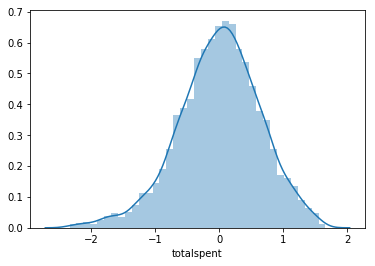

In [89]:
sns.distplot(residuals_f) # Residuals are Normal

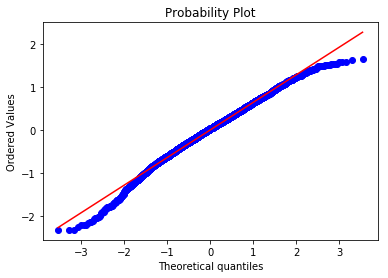

In [90]:
# To ensure residues are random i.e. normally distributed a Q-Q plot can be used
# Q-Q plot shows if the residuals are plotted along the line.
# Q-Q Plot seems to fine in Middle but not on the starting an Ending of the line 
stats.probplot( residuals_f, dist="norm", plot=pylab )
pylab.show()

C:\Users\raghu\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\raghu\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


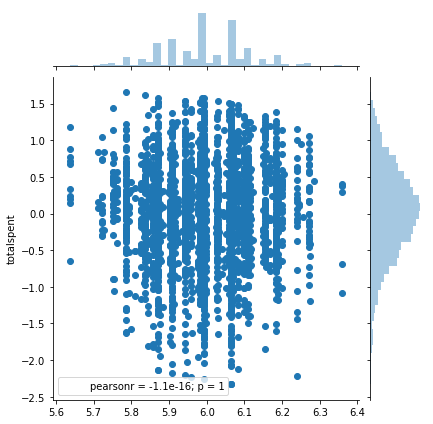

In [91]:
# Plot between Predicted and Residuals
sns.jointplot(y_pred_t_f,residuals_f)

#### Model formed using the f-Regression was not Good so Moving on Forward with the First Model 

### VIF and all for the first model 

In [92]:
all_columns = "+".join(train_X.columns)
# print (all_columns)
my_formula = "totalspent~" + all_columns
print (my_formula)

totalspent~const+age+agecat_3+agecat_4+agecat_5+agecat_6+card2_2+card2_3+card2_4+card2_5+card2items+card2tenure_26+card_2+card_3+card_4+card_5+carditems+cardtenure_39+ed+employ_16+employ_32+employ_34+equipten+gender_1+inccat_2+inccat_3+inccat_4+income+owncd_1+polview_6+reason_2+reason_9+retire_1+tenure


In [93]:
datanew=pd.concat([train_X,train_y],axis=1) # Concatenating Training X and Y Variables 

In [94]:
datanew.drop('agecat_6',axis=1,inplace=True) # Dropping Variables based on High VIF 

In [95]:
all_columns = "+".join(datanew.columns.difference( ['totalspent'] ))
# print (all_columns)
my_formula = "totalspent~" + all_columns

In [96]:
%%capture
#gather features
y, X = dmatrices(formula_like=my_formula,data=datanew, return_type='dataframe')

In [97]:
# Calculating VIF for Model 
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

C:\Users\raghu\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1543: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [98]:
# VIF is Good For all Variables 
vif.sort_values('VIF Factor',ascending=False)

,VIF Factor,features
1,3.232639,age
32,2.842130,retire_1
13,2.316367,card_4
7,2.271948,card2_4
6,2.131626,card2_3
5,2.077896,card2_2
11,2.059413,card_2
12,2.042483,card_3
33,1.962726,tenure
27,1.883705,income


In [99]:
# Appending all Variables names to a List 
datanew_var=[]
for var in datanew.columns:
    datanew_var.append(var)

In [100]:
# Removing "Constant" from the Variable Names list to Subset the Final Data  
datanew_var.remove('const')

In [101]:
# Subsetting the Final Data 
data_final=data[datanew_var]

In [102]:
data_final.head()

,age,agecat_3,agecat_4,agecat_5,card2_2,card2_3,card2_4,card2_5,card2items,card2tenure_26,...,inccat_3,inccat_4,income,owncd_1,polview_6,reason_2,reason_9,retire_1,tenure,totalspent
0,20.0,0,0,0,0,0,0,1,4.0,0,...,0,0,31.0,0,1,0,1,0,5.0,5.013697
1,22.0,0,0,0,0,0,1,0,2.0,0,...,0,0,15.0,1,0,0,1,0,39.0,4.363608
2,67.0,0,0,0,0,0,1,0,7.0,0,...,0,0,35.0,1,0,1,0,0,65.0,5.888795
3,23.0,0,0,0,0,1,0,0,1.0,0,...,0,0,20.0,1,0,0,1,0,36.0,5.887242
4,26.0,1,0,0,0,0,0,0,7.0,0,...,0,0,23.0,1,0,0,1,0,21.0,6.232114


In [103]:
feature_columns = data_final.columns.difference( ['totalspent'] )

In [104]:
feature_columns

Index(['age', 'agecat_3', 'agecat_4', 'agecat_5', 'card2_2', 'card2_3',
       'card2_4', 'card2_5', 'card2items', 'card2tenure_26', 'card_2',
       'card_3', 'card_4', 'card_5', 'carditems', 'cardtenure_39', 'ed',
       'employ_16', 'employ_32', 'employ_34', 'equipten', 'gender_1',
       'inccat_2', 'inccat_3', 'inccat_4', 'income', 'owncd_1', 'polview_6',
       'reason_2', 'reason_9', 'retire_1', 'tenure'],
      dtype='object')

In [105]:
# Splitting Training and Testing Data 
train_X, test_X, train_y, test_y = train_test_split( data_final[feature_columns],
                                                  data_final['totalspent'],
                                                  test_size = 0.3,
                                                  random_state = 123 )

In [106]:
## Building the model with train set and make predictions on test set
linreg = LinearRegression()
linreg.fit( train_X, train_y )

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [107]:
# Predicting on Training Data with the  Model 
y_pred_t = linreg.predict(train_X)
rmse_t = np.sqrt( metrics.mean_squared_error( train_y, y_pred_t) )
print (rmse_t)
print (metrics.r2_score( train_y, y_pred_t ))

0.35350124655992493
0.707702787513732


In [108]:
# Predicting on Testing Data With  the Model 
y_pred = linreg.predict( test_X )
rmse = np.sqrt( metrics.mean_squared_error( test_y, y_pred ) )
print (rmse)
print (metrics.r2_score( test_y, y_pred ))

0.3577347082572228
0.6605290060760819


In [109]:
# Rediduals 
residuals = train_y - y_pred_t

C:\Users\raghu\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


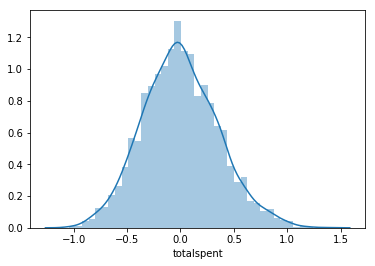

In [110]:
# Residuals Seems to be Normal
sns.distplot( residuals )

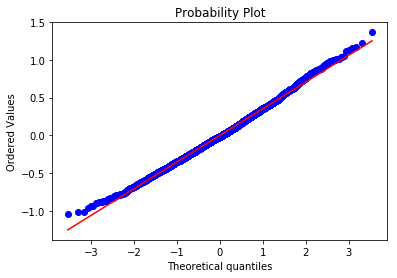

In [111]:
# To ensure residues are random i.e. normally distributed a Q-Q plot can be used
# Q-Q plot shows if the residuals are plotted along the line.
# Seems to be Fine 
stats.probplot( residuals, dist="norm", plot=pylab )
pylab.show()

C:\Users\raghu\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\raghu\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


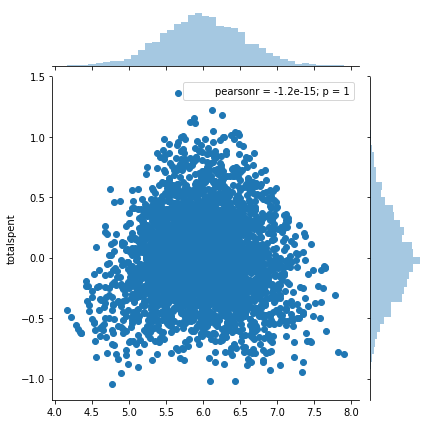

In [112]:
# Plot Between Predicted Y on Testing Data and Residuals
sns.jointplot(y_pred_t,residuals)